In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

# My numerical integration code for the induced charge on one strip of the nEXO detector.
## induced charge per unit area:
def induced_charge_per_unit(Q, dx, dy, dh):
    return Q*dh/(2*np.pi*np.power((dx**2+dy**2+dh**2), 1.5))

## Integral over one pad on a strip, (xc, yc, zc) is the coordinate of the point charge, (xp) is the center of the pad on the xaxis.
def integral_on_onePad(Q, xc, yc, zc, yp, PadSize=6., step=0.05):
    totalChargeOnePad = 0.
    PadEdge = PadSize/np.sqrt(2.)
    
    relativeX = xc/np.sqrt(2.) - (yc-yp)/np.sqrt(2.)
    relativeY = xc/np.sqrt(2.) + (yc-yp)/np.sqrt(2.)
    
    for xi in np.arange(-PadEdge/2., PadEdge/2., step):
        for yi in np.arange(-PadEdge/2., PadEdge/2., step):
            xc = xi + step/2.
            yc = yi + step/2.
            totalChargeOnePad += induced_charge_per_unit(Q, relativeX-xc, relativeY-yc, zc,)*step*step
    if zc > 0:
        return totalChargeOnePad
    elif zc == 0:  
        if (relativeX > -PadEdge/2.) & (relativeX < PadEdge/2.) & (relativeY > -PadEdge/2.) & (relativeY < PadEdge/2.):
            return Q
        else:
            return 0.

def integral_one_halfPad(Q, xc, yc, zc, yp, PadSize=6., step=0.05):
    totalChargeHalfPad = 0.
    PadEdge = PadSize/np.sqrt(2.)  
    relativeX = xc/np.sqrt(2.) - (yc-yp)/np.sqrt(2.)
    relativeY = xc/np.sqrt(2.) + (yc-yp)/np.sqrt(2.)

    for xi in np.arange(-PadEdge/2., PadEdge/2., step):
        ylow = -PadEdge/2.
        yhigh = ylow + (xi+PadEdge/2.)
        for yi in np.arange(ylow, yhigh, step):
            xc = xi + step/2.
            yc =-yi + step/2.
            totalChargeHalfPad += induced_charge_per_unit(Q, relativeX-xc, relativeY-yc, zc,) * step*step
    if zc > 0:
        return totalChargeHalfPad
    elif zc == 0:  
        if relativeX > -PadEdge/2. and relativeX < PadEdge/2. :
            if relativeY > -PadEdge/2. and relativeY < relativeX:
                return Q
        else:
            return 0.


        
        
## Sum up all pads on the strip.        
def sumup_pads_oneStrip(Q, xc, yc, zc, step):
    '''
    Q_strip = 0.
    for xp in np.arange(-48, 48, 6):
        Q_strip += integral_on_onePad(Q, xc, yc, zc, xp, step=step)
    return Q_strip
    '''
    Q_strip = 0.
    for xp in np.arange(-42, 48, 6):
        Q_strip += integral_on_onePad(Q, xc, yc, zc, xp, step=step)
    Q_strip += 2 * integral_one_halfPad(Q, xc, yc, zc, 48, step=step)
    return Q_strip

def waveforms_oneStrip(Q, xc, yc, zc, z_step=1., xy_step=0.05, v_drift=1.7):
    t, wf = [], []
    for z in tqdm(np.arange(zc, -z_step, -z_step)):
        t.append( (zc-z)/v_drift)
        wf.append( sumup_pads_oneStrip(Q, xc, yc, z, step=xy_step))
    t = np.array(t)
    wf = np.array(wf)
    return t, wf

In [10]:
# Test config:
Q0, x0, y0, z0 = 1e5, 2, 1, 200.
v_drift = 1.70

In [16]:
time_numericalIntegral, wf_numericalIntegral = waveforms_oneStrip(Q0, x0, y0, z0, xy_step=0.05, z_step=0.05)

100%|█████████▉| 4000/4001 [19:00<00:00,  3.51it/s]


TypeError: unsupported operand type(s) for +=: 'float' and 'NoneType'

In [6]:
import sys
sys.path.append('/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/nEXO_reconstruction/')
from scripts.SignalCalculator import SignalCalculator
from scripts.nEXOFieldWP import nEXOFieldWP

In [11]:
t, wf = SignalCalculator.ComputeChargeWaveformOnStrip(Q0, x0, y0, z0, numWfmPoints=200)

/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/nEXO_reconstruction/scripts/SignalCalculator/SignalCalculator.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/nEXO_reconstruction/scripts/SignalCalculator/SignalCalculator.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


In [12]:
from scripts.waveform_WP import waveform_WP
wave = waveform_WP()
wave.initialize()
#wave.initialize_PCDZ()
#wave.initialize_ZSeq()
anodeZ = -402.97
fMinZ, fMaxZ = anodeZ-z0-10, anodeZ-z0+10
wave.DetermineSamplingSequence(fMaxZ, fMinZ)
wave.CalcWaveformOnChannel(0, 0, 'xstrip', [{'x': x0, 'y': y0, 'z': z0, 'q': Q0}])
wave_time, wave_wf = wave.onechannel_time, wave.onechannel_wf

(dx, dy) = (2, 1), (dx_a, dy_a) = (2.0, 1.0).
Fetching histogram: wp_x10_y5


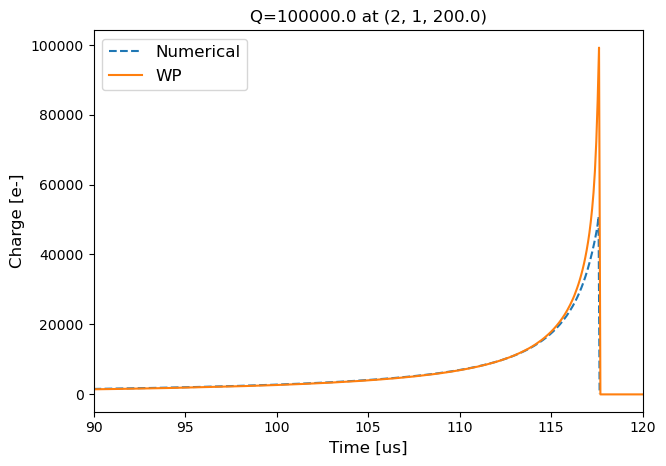

In [17]:
# Compare three different ways of the charge waveform.

_, ax = plt.subplots(figsize=(7, 5))
#ax.plot(t, wf, '-', label='Analytical')

ax.plot(time_numericalIntegral, wf_numericalIntegral, '--', label='Numerical')

ax.plot(wave_time, wave_wf, label="WP")

ax.set_xlim(90, 120)
ax.set_xlabel('Time [us]', fontsize=12)
ax.set_ylabel('Charge [e-]', fontsize=12)
ax.tick_params(labelsize=10)
ax.legend(prop={'size': 12})
ax.set_title(f'Q={Q0} at ({x0}, {y0}, {z0})', fontsize=12)
plt.tight_layout()

In [9]:
# Compare numerical/analytical integration of the charge waveform

Q1, x1, y1, z1 = 1e5, 0, 0, 400

time_numericalIntegral1, wf_numericalIntegral1 = waveforms_oneStrip(Q1, x1, y1, z1)
time_analytical1, wf_analytical1 = SignalCalculator.ComputeChargeWaveformOnStripWithIons(Q1, x1, y1, z1)
anodeZ = -402.97
fMinZ, fMaxZ = anodeZ-z0-10, anodeZ-z0+10
wave.DetermineSamplingSequence(fMaxZ, fMinZ)
wave.CalcWaveformOnChannel(0, 0, 'ystrip', [{'x': x1, 'y': y1, 'z': z1, 'q': Q1}])
wave_time1, wave_wf1 = wave.onechannel_time, wave.onechannel_wf

Q2, x2, y2, z2 = 1e5, 1, 1, 400
time_numericalIntegral2, wf_numericalIntegral2 = waveforms_oneStrip(Q2, x2, y2, z2)
time_analytical2, wf_analytical2 = SignalCalculator.ComputeChargeWaveformOnStripWithIons(Q2, x2, y2, z2)
anodeZ = -402.97
fMinZ, fMaxZ = anodeZ-z0-10, anodeZ-z0+10
wave.DetermineSamplingSequence(fMaxZ, fMinZ)
wave.CalcWaveformOnChannel(0, 0, 'ystrip', [{'x': x2, 'y': y2, 'z': z2, 'q': Q2}])
wave_time2, wave_wf2 = wave.onechannel_time, wave.onechannel_wf

Q3, x3, y3, z3 = 1e5, 2, 2, 400
time_numericalIntegral3, wf_numericalIntegral3 = waveforms_oneStrip(Q3, x3, y3, z3)
time_analytical3, wf_analytical3 = SignalCalculator.ComputeChargeWaveformOnStripWithIons(Q3, x3, y3, z3)
anodeZ = -402.97
fMinZ, fMaxZ = anodeZ-z0-10, anodeZ-z0+10
wave.DetermineSamplingSequence(fMaxZ, fMinZ)
wave.CalcWaveformOnChannel(0, 0, 'ystrip', [{'x': x3, 'y': y3, 'z': z3, 'q': Q3}])
wave_time3, wave_wf3 = wave.onechannel_time, wave.onechannel_wf

Q4, x4, y4, z4 = 1e5, 1, 0, 400
time_numericalIntegral4, wf_numericalIntegral4 = waveforms_oneStrip(Q4, x4, y4, z4)
time_analytical4, wf_analytical4 = SignalCalculator.ComputeChargeWaveformOnStripWithIons(Q4, x4, y4, z4)
anodeZ = -402.97
fMinZ, fMaxZ = anodeZ-z0-10, anodeZ-z0+10
wave.DetermineSamplingSequence(fMaxZ, fMinZ)
wave.CalcWaveformOnChannel(0, 0, 'ystrip', [{'x': x4, 'y': y4, 'z': z4, 'q': Q4}])
wave_time4, wave_wf4 = wave.onechannel_time, wave.onechannel_wf

100%|██████████| 401/401 [01:24<00:00,  4.76it/s]
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/nEXO_reconstruction/scripts/SignalCalculator/SignalCalculator.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))
/Users/yumiao/Documents/Works/0nbb/nEXO/Reconstruction/waveform/nEXO_reconstruction/scripts/SignalCalculator/SignalCalculator.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


(dx, dy) = (0, 0), (dx_a, dy_a) = (0.0, 0.0).
Fetching histogram: wp_x1_y1


100%|██████████| 401/401 [01:24<00:00,  4.73it/s]


(dx, dy) = (1, 1), (dx_a, dy_a) = (1.0, 1.0).
Fetching histogram: wp_x6_y6


100%|██████████| 401/401 [01:25<00:00,  4.72it/s]


(dx, dy) = (2, 2), (dx_a, dy_a) = (2.0, 2.0).
Fetching histogram: wp_x11_y11


100%|██████████| 401/401 [01:23<00:00,  4.78it/s]


(dx, dy) = (0, 1), (dx_a, dy_a) = (0.0, 1.0).
Fetching histogram: wp_x1_y6


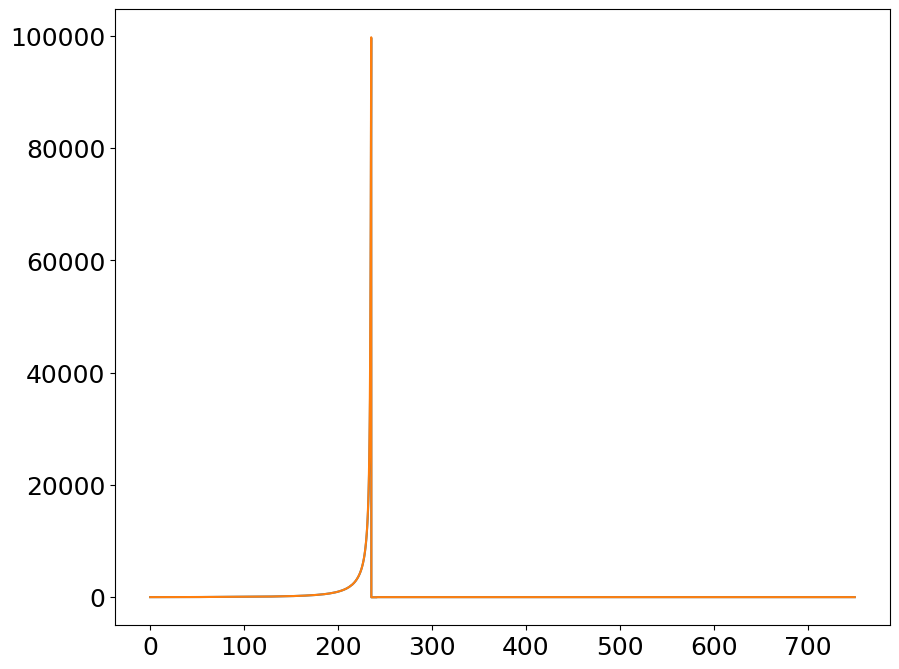

In [10]:
plt.plot(wave_time, wave_wf, label="WP")
plt.plot(wave_time1, wave_wf1, label="WP1")

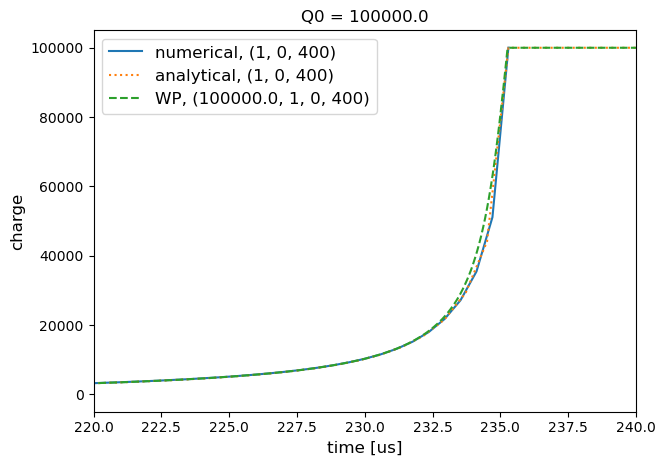

In [16]:
_, ax = plt.subplots(figsize=(7, 5))
#ax.plot(time_numericalIntegral1, wf_numericalIntegral1, label=f'numerical, ({x1}, {y1}, {z1})')
#ax.plot(time_numericalIntegral2, wf_numericalIntegral2, label=f'numerical, ({x2}, {y2}, {z2})')
#ax.plot(time_numericalIntegral3, wf_numericalIntegral3, label=f'numerical, ({x3}, {y3}, {z3})')
ax.plot(time_numericalIntegral4, wf_numericalIntegral4, label=f'numerical, ({x4}, {y4}, {z4})')
#ax.plot(time_analytical1, wf_analytical1, ':', label=f'analytical, ({x1}, {y1}, {z1})')
#ax.plot(time_analytical2, wf_analytical2, ':', label=f'analytical, ({x2}, {y2}, {z2})')
#ax.plot(time_analytical3, wf_analytical3, ':', label=f'analytical, ({x3}, {y3}, {z3})')
ax.plot(time_analytical4, wf_analytical4, ':', label=f'analytical, ({x4}, {y4}, {z4})')
#ax.plot(wave_time1, wave_wf1, '--', label=f'WP, ({Q1}, {x1}, {y1}, {z1})')
#ax.plot(wave_time2, wave_wf2, '--', label=f'WP, ({Q2}, {x2}, {y2}, {z2})')
#ax.plot(wave_time3, wave_wf3, '--', label=f'WP, ({Q3}, {x3}, {y3}, {z3})')
ax.plot(wave_time4, wave_wf4, '--', label=f'WP, ({Q4}, {x4}, {y4}, {z4})')
ax.set_title(f'Q0 = {1e5}', fontsize=12)
ax.set_xlabel('time [us]', fontsize=12)
ax.set_ylabel('charge', fontsize=12)
ax.legend(prop={'size': 12})
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlim(220, 240)
plt.tight_layout()

In [66]:
t1, wf1 = waveforms_oneStrip(Q0, x0, y0, z0, xy_step=0.02)
t2, wf2 = waveforms_oneStrip(Q0, x0, y0, z0, xy_step=0.05)
t3, wf3 = waveforms_oneStrip(Q0, x0, y0, z0, xy_step=0.1)
t4, wf4 = waveforms_oneStrip(Q0, x0, y0, z0, xy_step=0.5)

100%|██████████| 301/301 [00:00<00:00, 301.78it/s]


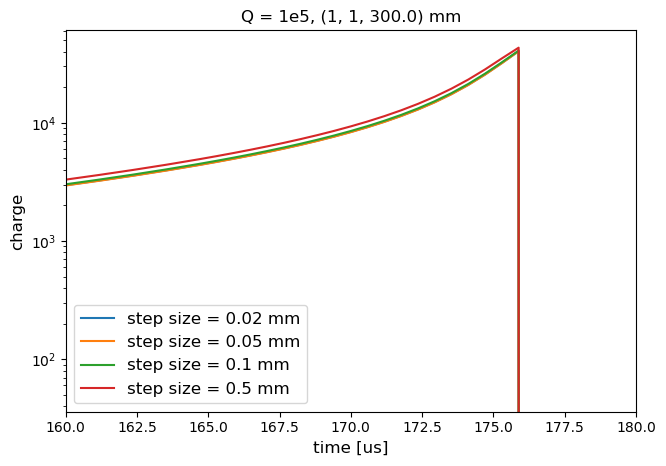

In [72]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(t1, wf1, '-', label='step size = 0.02 mm')
ax.plot(t2, wf2, '-', label='step size = 0.05 mm')
ax.plot(t3, wf3, '-', label='step size = 0.1 mm')
ax.plot(t4, wf4, '-', label='step size = 0.5 mm')
ax.set_xlabel('time [us]', fontsize=12)
ax.set_ylabel('charge', fontsize=12)
ax.legend(prop={'size': 12}, loc='lower left')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlim(160, 180)
ax.semilogy()
ax.set_title(f'Q = 1e5, ({x0}, {y0}, {z0}) mm', fontsize=12)
plt.tight_layout()

Fetching histogram: wp_x10_y10
Fetching histogram: wp_x15_y5
Fetching histogram: wp_x15_y10
Fetching histogram: wp_x15_y15


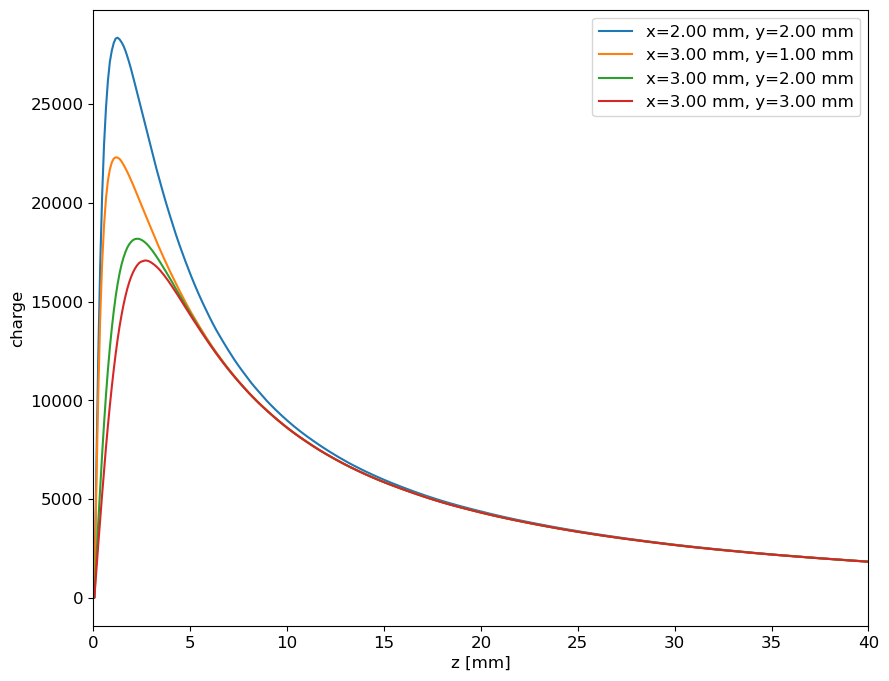

In [24]:
from scripts.nEXOFieldWP import nEXOFieldWP
wp = nEXOFieldWP()
wp._load_axes()

# On the strip
#xs = [0.0, 0.0, 0.0, 1.0, 2.0, 1.0]
#ys = [0.0, 1.0, 2.0, 0.0, 0.0, 1.0]
# On the edge
xs = [3.0, 2.0, 1.0, 0.0]
ys = [0.0, 1.0, 2.0, 3.0]
# Out the strip
xs = [2.0, 3.0, 3.0, 3.0]
ys = [2.0, 1.0, 2.0, 3.0]

for x, y in zip(xs, ys):
    i, j = wp.GetXBin(x), wp.GetYBin(y)
    wp.GetHist(i, j)
    t1, wp1 = wp.x, wp.y
    plt.plot(t1, wp1, '-', label=f'x={x:.2f} mm, y={y:.2f} mm')
plt.xlim(0, 40)
plt.xlabel('z [mm]', fontsize=12)
plt.ylabel('charge', fontsize=12)
plt.legend(prop={'size': 12})
plt.tick_params(labelsize=12)

In [23]:
print(wp1)

[     0.    100000.     72306.664 ...      0.         0.         0.   ]


In [37]:
import pandas as pd
arr = pd.read_csv('../maps/channelPos_tile92.txt')
print(arr.keys())
xstrip = arr[arr['type']=='X']
xstrip_x = xstrip['x'].values
xstrip_y = xstrip['y'].values
ystrip = arr[arr['type']=='Y']
ystrip_x = ystrip['x'].values
ystrip_y = ystrip['y'].values

Index(['cha', 'type', 'x', 'y'], dtype='object')


Text(0.5, 1.0, 'Channel position on one tile')

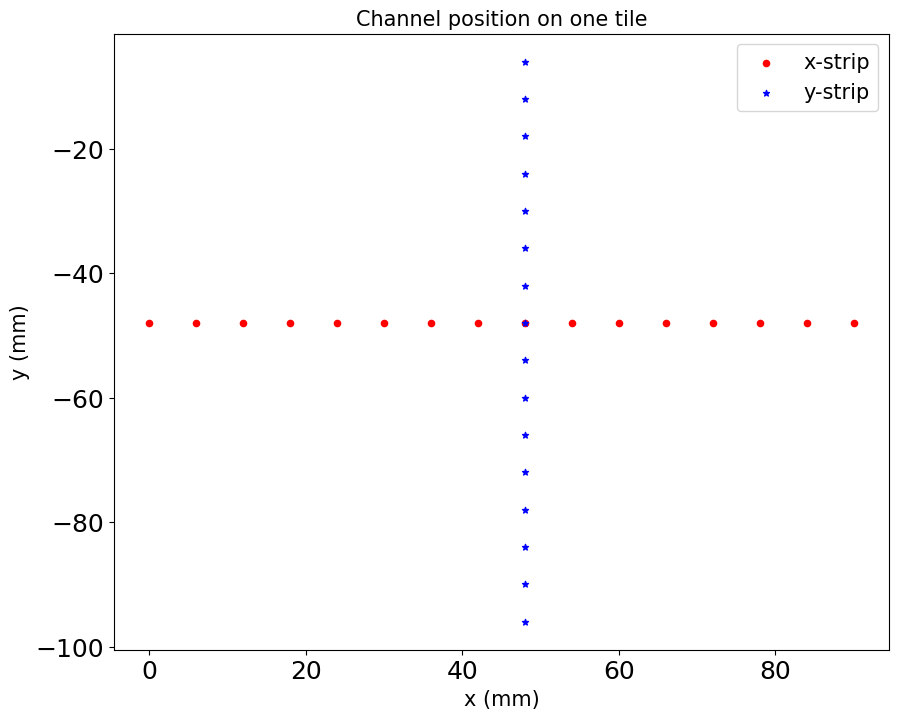

In [41]:
plt.scatter(xstrip_x, xstrip_y, s=20, c='r', marker='o', label='x-strip')
plt.scatter(ystrip_x, ystrip_y, s=20, c='b', marker='*', label='y-strip')
plt.legend(prop={'size': 15})
plt.xlabel('x (mm)', fontsize=15)
plt.ylabel('y (mm)', fontsize=15)
plt.title('Channel position on one tile', fontsize=15)